Several things of note:
* There are 2 target values to an equal or larger range of feature values.
    * Target values are a 1x2 array, whereas features will depend on our selection of time intervals and will be of the form Nx6; where N is $\frac{\Delta t}{\delta t}$, $\Delta T$, how far back in time before the 'present' we take values from, and $\delta t$ the time interval length (1 min. in our case).
        * This means that we have a hyperparameter $\Delta T$ that we need to decide on how we tune.
            * The most apparent ways we can do this are:
                1. We simply take the best performing overall value for it; this being after fitting for each potential value and potential data set and comparing. (i.e. Grid search)
                2. We use another supervised model to predict the best performing hyper-parameter given the feature data. 
                    * This could also involve deciding the parameters of a weighting function that gives a weight as a function of $n \cdot \delta t$, where n is the interval number.  
                    * The reason to do this would be that potentially the current conditions will determine how far in the past  and how much predictive power the data holds. (e.g. A high current speed may mean that only very recent data is relevant.)
                3. We take an arbitrary number we decide via some intuitive reason.
            
            * This will likely be unnecessary for the Neural networks as they will likely account for the weighting if we feed it the entire intervals data.
            
            

* Potential models we will try to work with are:
    * Linear regression:
        * This is basic, but will be explored jout for comparison.
        
    * Random Forest regressor
        * 
        
    * Neural networks:
        * Artificial Neural network.
        * Recurrent Neural network.
        * Potentially deep variants of the above.
  
* 

First we read in the data to be used to develop the models.

In [158]:
import pandas as pd
import numpy as np

# Load data.
df_train = pd.read_csv("../../../data/sag_data_train.csv", parse_dates=True)

# Set up time column
time = df_train['Time'] 

# Feature matrix X
X = pd.read_csv("../../../data/sag_data_train.csv", index_col="Time", parse_dates=True) 

We will start with a basic linear regression to test if it does better than the baseline.

In [79]:
from sklearn.linear_model import LinearRegression

# We want to remove the first five rows of both dataframes since they don't have target values
y_lr = y_lr.drop(y_lr.index[range(5)])
X_lr = X.drop(X.index[range(5)])

y_lr

# deprecated means of aligning data columns after removing all data rows with NAN values
## Match matrix lengths by indicies.
#for X_index in X.index:
#    index_exists_in_both = False
#    for y_index in y.index:
#        if y_index == X_index:
#            index_exists_in_both = True
#        
#    print(X_index, X.index[X_index])
#    
#    if index_exists_in_both == False:
#        y.drop(X_index)
#        X.drop(X_index)

,Future Bearing Pressure,Future Power Draw
Time,,
2015-09-15 00:10:00,5487.269091,11.691652
2015-09-15 00:11:00,5480.270457,11.673803
2015-09-15 00:12:00,5483.381183,11.489922
2015-09-15 00:13:00,5487.186353,11.604724
2015-09-15 00:14:00,5453.889300,11.784436
...,...,...
2015-12-19 23:56:00,5311.644590,13.595722
2015-12-19 23:57:00,5330.085622,13.352943
2015-12-19 23:58:00,5300.893807,12.989011


Now we want to set up a validation method for optimizing our model.

In order to do this, we will split all of our data into 30 minute segments (on the assumption that longer than that won't be a relevent for the prediction).

In [80]:
from sklearn.model_selection import TimeSeriesSplit # for time series model validation

tscv = TimeSeriesSplit(n_splits=5) 
score = []

# Large quantity of data means that losing one set from rounding is likely inconsequential.
for t in range(round(X_lr.shape[0]/30)): # half hour intervals since each interval is 1 minute
    sample_X = X_lr.reset_index(drop=True).iloc[t*30:(t+1)*30]
    sample_y = y_lr.reset_index(drop=True).iloc[t*30:(t+1)*30]
    split_n = 1

    for train_index, test_index in tscv.split(sample_X): # split data for validation
        
        X_train, X_test = sample_X.iloc[train_index], sample_X.iloc[test_index]
        y_train, y_test = sample_y.iloc[train_index], sample_y.iloc[test_index]  
        
        # Here, in case of a NAN value being present, we replace these NAN values with the set mean value. This is done here to prevent 'information leakage' between sets.
        # If there are 5 consecutive NAN values though there will be a problem. For this data set we know this is impossible though.
        y_train = y_train.fillna(y_train.mean())
        X_train = X_train.fillna(X_train.mean())
        
        lr_sample = LinearRegression(fit_intercept=False, n_jobs=-1).fit(X_train, y_train)
        score.append([t, split_n, lr_sample.score(X_test, y_test)])
        split_n += 1
        
        ## Here we do two differenct linear regressions for each target variable
        #lr_bearing_pressure = LinearRegression(fit_intercept=False, n_jobs=-1).fit(X_train, y_train['Future Bearing Pressure'])
        #lr_power_draw = LinearRegression(fit_intercept=False, n_jobs=-1).fit(X_train, y_train['Future Power Draw'])
        #score.append([t, lr_bearing_pressure.score(X_test, y_test['Future Bearing Pressure']), lr_power_draw.score(X_test, y_test['Future Power Draw'])])

display(score)


AttributeError: 'list' object has no attribute 'head'

At first glance, the model doesn't do well at all, to confirm:

In [83]:
df_score = pd.DataFrame(score, columns=['30 min. interval no.', 'Split no.','R sq. score of model'])


df_score.groupby(['Split no.']).mean()

,30 min. interval no.,R sq. score of model
Split no.,,
1,2303.5,-2.669852e+22
2,2303.5,-4.220212e+14
3,2303.5,-7.438872e+14
4,2303.5,-1.117319e+09
5,2303.5,-4.704272e+14


For all splits the scores are very negative, this indicates a straight line would do better. We will plot the last model's predictions to see what is happening.

,Predicted Bearing Pressure,Predicted Power Draw
138228,5300.261899,13.492852
138229,5291.085530,13.343488
138230,5309.158629,13.007053


,Future Bearing Pressure,Future Power Draw,Time (minutes)
138228,5300.893807,12.989011,NaN
138229,5319.902014,13.330749,NaN
138230,5331.208153,13.496682,NaN


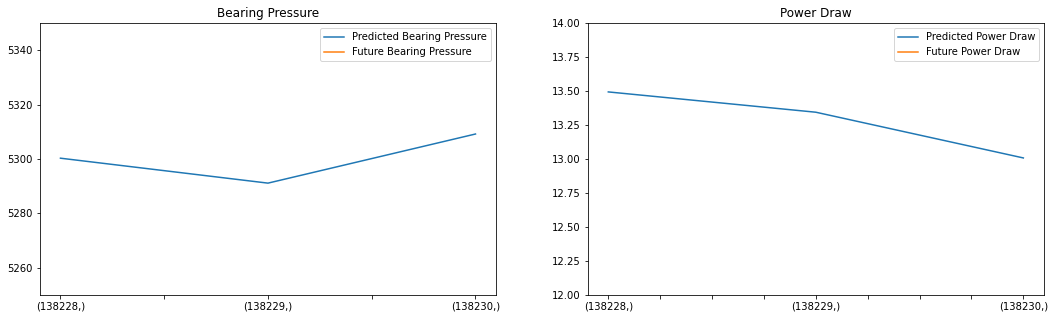

In [156]:
%matplotlib inline
import matplotlib.pyplot as plt

example_actual_values = y_test
example_predicted_values = pd.DataFrame(lr_sample.predict(X_test), columns=['Predicted Bearing Pressure','Predicted Power Draw'], index=[example_actual_values.index])

BP_comparison_df = pd.DataFrame()
BP_comparison_df['Predicted Bearing Pressure'] = example_predicted_values['Predicted Bearing Pressure']
BP_comparison_df['Future Bearing Pressure'] = example_actual_values['Future Bearing Pressure']


PD_comparison_df = pd.DataFrame()
PD_comparison_df['Predicted Power Draw'] = example_predicted_values['Predicted Power Draw']
PD_comparison_df['Future Power Draw'] = example_actual_values['Future Power Draw']


fig, axes = plt.subplots(ncols=2)
BP_comparison_df.plot(ax=axes[0]).set_ylim(5250,5350); axes[0].set_title('Bearing Pressure')
PD_comparison_df.plot(ax=axes[1], figsize=(18,5)).set_ylim(12,14); axes[1].set_title('Power Draw')
                                                                
display(example_predicted_values, example_actual_values)


#display(test_lr.predict(X_test), y_test)
#lr_bearing_pressure.predict(X_test, y_test['Future Bearing Pressure'])
#lr_power_draw.predict(X_test, y_test['Future Power Draw'])
#print(X_test,'this was x_test and this is Y_test:\n', y_test['Future Power Draw'], 'bearing pressure \n',X_test, y_test['Future Bearing Pressure'])


Moving on, we'll move on to the most likely candidate for an accurate prediction out of those mentioned, the RNN. We will use an LSTM forecast model.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Load data into numpy array and ensure all data is float.
values = X.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning




tscv = TimeSeriesSplit(n_splits=5)
score = []


# Split data into several independent problems.
for t in range(round(X.shape[0]/30)): # half hour intervals since each interval is 1 minute
    # Format into supervised format
    sample_X = X.reset_index(drop=True).iloc[t*30:(t+1)*30-5]
    sample_y = X.reset_index(drop=True).iloc[t*30:(t+1)*30]

    for train_index, test_index in tscv.split(sample_X): # split data for validation
        # Here, in case of a NAN value being present, we replace these NAN values with the set mean value. This is done here to prevent 'information leakage' between sets.
        # If there are 5 consecutive NAN values though there will be a problem. For this data set we know this is impossible though.
        y = y.fillna(y.mean())
        X = X.fillna(X.mean())
        
        X_train, X_test = sample_X.iloc[train_index], sample_X.iloc[test_index]
        y_train, y_test = sample_y.iloc[train_index], sample_y.iloc[test_index]  
        
        # Here we do two differenct linear regressions for each target variable
        lr_bearing_pressure = LinearRegression(fit_intercept=False, n_jobs=-1).fit(X_train, y_train['Future Bearing Pressure'])
        lr_power_draw = LinearRegression(fit_intercept=False, n_jobs=-1).fit(X_train, y_train['Future Power Draw'])
        score.append([t, lr_bearing_pressure.score(X_test, y_test['Future Bearing Pressure']), lr_power_draw.score(X_test, y_test['Future Power Draw'])])

display(score.head(),score.tail())
a

Now the test data set is loaded in for testing and error analysis.

In [ ]:
df_test = pd.read_csv("../../../data/sag_data_test.csv", index_col="Time", parse_dates=True)

X_baseline_test =
y_baseline_test['Future Bearing Pressure'] = X['Bearing Pressure (kPa)'].shift(periods=5)
y_baseline_test['Future Power Draw'] = X['Power Draw (MW)'].shift(periods=5)